In [52]:
# ========== ЗАДАНИЕ №1 ==========

# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import ode

# Настройки отображения графиков
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [53]:
# ========== Пункт 1: Точное решение ==========
def some_foo(t, e):
    """Аналитическое решение уравнения εds/dt + s = 0"""
    return np.exp(-t/e)

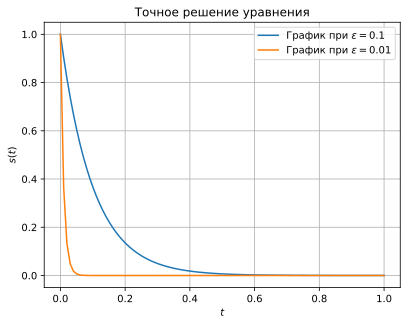

In [54]:
# ========== Пункт 2: Графики точного решения ==========
# Построение графиков точного решения для разных ε
e1 = 0.1
e2 = 0.01

t = np.linspace(0, 1, 100)
s = [some_foo(i, e1) for i in t]
plt.plot(t, s, label='График при $\\epsilon = 0.1$')

s2 = [some_foo(i, e2) for i in t]
plt.plot(t, s2, label='График при $\\epsilon = 0.01$')

plt.grid(True)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$s(t)$')
plt.title('Точное решение уравнения')
plt.show()


In [55]:
# ========== Пункт 3: Численное решение методом Эйлера ==========
def euler_solve(t0, t1, y0, epsilon, n_points):
    """Решение уравнения методом Эйлера"""
    t, h = np.linspace(t0, t1, n_points, retstep=True)
    s = [y0]
    s_current = y0

    for i in range(1, n_points):
        # Явная схема Эйлера: s_{n+1} = s_n - (h/ε)*s_n
        s_next = s_current * (1 - h/epsilon)
        s.append(s_next)
        s_current = s_next

    return t, s

# Параметры для численного решения
t0, t1, s0 = 0, 1, 1
epsilon = 0.01

# Решение с разными шагами
dt1, dt2 = 0.02, 0.002
n1 = int((t1 - t0)/dt1)
n2 = int((t1 - t0)/dt2)

t_euler1, s_euler1 = euler_solve(t0, t1, s0, epsilon, n1)
t_euler2, s_euler2 = euler_solve(t0, t1, s0, epsilon, n2)


In [56]:
# ========== Пункт 3: Численное решение методом Эйлера ==========
def euler_solve(t0, t1, y0, e, n):
    """Решение уравнения методом Эйлера (ваш исходный метод)"""
    t, h = np.linspace(t0, t1, n, retstep=True)
    s = [y0]
    s_n = y0
    for i in t[1:]:
        s_n_1 = s_n/(1+h/e)
        s.append(s_n_1)
        s_n = s_n_1
    return t, s

# Параметры для численного решения
t_0 = 0
t_1 = 1
s_0 = 1
e = 0.01
dt_1 = 0.02
dt_2 = 0.002
n1 = int((t_1 - t_0)/dt_1)
n2 = int((t_1 - t_0)/dt_2)

# Решение с разными шагами
t1, s1 = euler_solve(t_0, t_1, s_0, e, n1)
t2, s2 = euler_solve(t_0, t_1, s_0, e, n2)

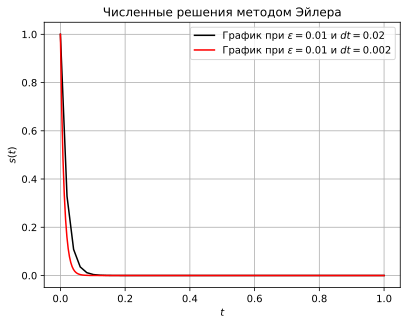

In [57]:
# ========== Пункт 4: Графики численных решений ==========
plt.plot(t1, s1, label=f'График при $\\epsilon = {e}$ и $dt = {dt_1}$', color='black')
plt.plot(t2, s2, label=f'График при $\\epsilon = {e}$ и $dt = {dt_2}$', color='red')

plt.grid(True)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$s(t)$')
plt.title('Численные решения методом Эйлера')
plt.show()

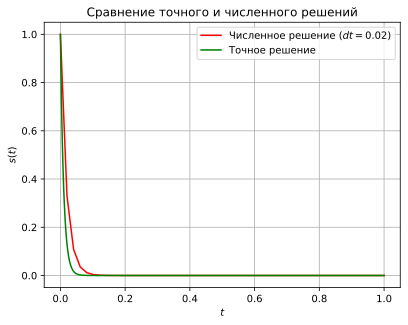

In [58]:
# ========== Сравнение с точным решением ==========
plt.plot(t1, s1, label=f'Численное решение ($dt = {dt_1}$)', color='red')
t_exact = np.linspace(0, 1, 500)
s_exact = some_foo(t_exact, e)
plt.plot(t_exact, s_exact, label=f'Точное решение', color='green')

plt.grid(True)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$s(t)$')
plt.title('Сравнение точного и численного решений')
plt.show()

In [59]:
# ========== Оценка ошибки ==========
# Интерполяция для сравнения на одинаковых точках
s_euler_interp = np.interp(t_exact, t2, s2)

# Вычисление ошибки
E = np.sqrt(1/(len(t_exact)) * np.sum((s_exact - s_euler_interp)**2))
print(f"Оценка ошибки аппроксимации: {E:.6f}")

Оценка ошибки аппроксимации: 0.004739


In [60]:
# ========== ЗАДАНИЕ №2 ==========

# ========== Пункт 1-2: Модификация системы с силой тяги ==========
import numpy as np
from math import *

# Константы для вычислений
grad = pi/180
g = 9.81
ro = 1.240
a = 340

def C_x(M):
    return 0.44

def thrust_profile(t):
    """
    Произвольный профиль тяги
    Тяга действует первые 2 секунды
    """
    if t <= 2.0:
        return 50.0  # Постоянная тяга 50 Н
    else:
        return 0.0

# Начальные условия (оставляем исходные)
x_0 = 0
y_0 = 0
V_0 = 100
thetta_0 = 30
mass = 30
S_m = pi*0.1**2/4

# Начальные условия в векторной форме
Y_0 = np.array([
    x_0,
    y_0,
    V_0*cos(thetta_0*grad),
    V_0*sin(thetta_0*grad),
    0,  # P_x начальное
    0   # P_y начальное
])

def f(t, Y):
    """Система ОДУ для движения с сопротивлением и тягой"""
    x = Y[0]
    y = Y[1]
    V_x = Y[2]
    V_y = Y[3]
    P_x = Y[4]
    P_y = Y[5]

    # Вычисление тяги в текущий момент времени
    P = thrust_profile(t)

    # Угол вектора скорости для направления тяги
    theta = np.arctan2(V_y, V_x)

    # Обновляем компоненты тяги
    P_x = P * np.cos(theta)
    P_y = P * np.sin(theta)

    V = np.sqrt(V_x**2 + V_y**2)
    N = mass*g
    M = V/a
    F_drag = 0.5 * ro * V**2 * S_m * C_x(M)

    a_x = (-F_drag * np.cos(theta) + P_x)/mass
    a_y = (-F_drag * np.sin(theta) + P_y - N)/mass

    return np.array([
        V_x,
        V_y,
        a_x,
        a_y,
        0,  # производная от P_x (не используется)
        0   # производная от P_y (не используется)
    ])

In [61]:
# ========== Ваш исходный метод Эйлера для системы ОДУ ==========
def euler(t_0, t_1, y_0, dYdt, n_points):
    """Ваш исходный метод Эйлера для систем ОДУ"""
    dt = (t_1 - t_0) / n_points
    t = np.linspace(t_0, t_1, n_points)
    y = np.zeros((n_points, len(y_0)))
    y[0] = y_0

    for i in range(1, n_points):
        dydt = dYdt(t[i-1], y[i-1])
        y[i] = y[i-1] + dt * dydt

    return y, t

# Решение системы вашим методом Эйлера
y_euler, t_euler = euler(0, 7, Y_0, f, 100)

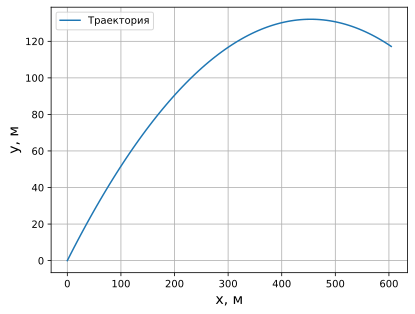

In [62]:
# ========== Графики из исходного файла ==========
# График траектории (ваш исходный)
xs = y_euler[:,0]
ys = y_euler[:,1]
plt.plot(xs, ys, label='Траектория')
plt.grid()
plt.xlabel('x, м', fontsize=14)
plt.ylabel('y, м', fontsize=14)
plt.legend(loc='best')
plt.show()


In [63]:
# ========== Пункт 3-4: Решение с помощью scipy.integrate.ode ==========
def solve_with_scipy():
    """Решение системы ОДУ с остановкой при падении на землю"""
    # Создаем решатель
    solver = ode(f)
    solver.set_integrator('dopri5')  # метод Дорманда-Принса 5 порядка
    solver.set_initial_value(Y_0, 0)

    # Векторы для хранения результатов
    t_values = [0]
    Y_values = [Y_0.copy()]
    thrust_values = [thrust_profile(0)]

    # Интегрируем до падения на землю (y < 0)
    dt = 0.01
    while solver.successful() and solver.y[1] >= 0:
        solver.integrate(solver.t + dt)
        t_values.append(solver.t)
        Y_values.append(solver.y.copy())
        thrust_values.append(thrust_profile(solver.t))

    return np.array(t_values), np.array(Y_values), np.array(thrust_values)

# Решаем систему
t_scipy, Y_scipy, thrust_scipy = solve_with_scipy()

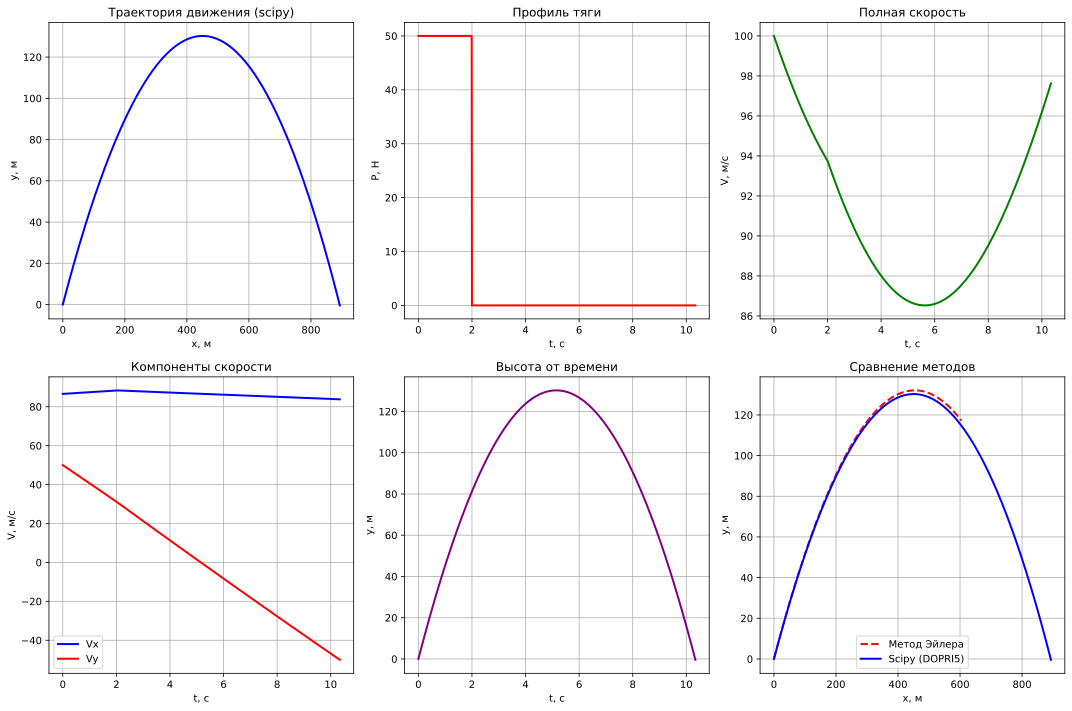

In [64]:
# ========== Пункт 5: Графики траектории и профиля тяги ==========
# Создаем фигуру с несколькими графиками как в исходном файле
plt.figure(figsize=(15, 10))

# График 1: Траектория движения (scipy)
plt.subplot(2, 3, 1)
plt.plot(Y_scipy[:, 0], Y_scipy[:, 1], 'b-', linewidth=2)
plt.grid(True)
plt.xlabel('x, м')
plt.ylabel('y, м')
plt.title('Траектория движения (scipy)')

# График 2: Профиль тяги
plt.subplot(2, 3, 2)
plt.plot(t_scipy, thrust_scipy, 'r-', linewidth=2)
plt.grid(True)
plt.xlabel('t, с')
plt.ylabel('P, Н')
plt.title('Профиль тяги')

# График 3: Скорость по времени
plt.subplot(2, 3, 3)
V_total = np.sqrt(Y_scipy[:, 2]**2 + Y_scipy[:, 3]**2)
plt.plot(t_scipy, V_total, 'g-', linewidth=2)
plt.grid(True)
plt.xlabel('t, с')
plt.ylabel('V, м/с')
plt.title('Полная скорость')

# График 4: Компоненты скорости
plt.subplot(2, 3, 4)
plt.plot(t_scipy, Y_scipy[:, 2], 'b-', label='Vx', linewidth=2)
plt.plot(t_scipy, Y_scipy[:, 3], 'r-', label='Vy', linewidth=2)
plt.grid(True)
plt.xlabel('t, с')
plt.ylabel('V, м/с')
plt.title('Компоненты скорости')
plt.legend()

# График 5: Высота от времени
plt.subplot(2, 3, 5)
plt.plot(t_scipy, Y_scipy[:, 1], 'purple', linewidth=2)
plt.grid(True)
plt.xlabel('t, с')
plt.ylabel('y, м')
plt.title('Высота от времени')

# График 6: Сравнение траекторий (Эйлер vs Scipy)
plt.subplot(2, 3, 6)
plt.plot(y_euler[:, 0], y_euler[:, 1], 'r--', label='Метод Эйлера', linewidth=2)
plt.plot(Y_scipy[:, 0], Y_scipy[:, 1], 'b-', label='Scipy (DOPRI5)', linewidth=2)
plt.grid(True)
plt.xlabel('x, м')
plt.ylabel('y, м')
plt.title('Сравнение методов')
plt.legend()

plt.tight_layout()
plt.show()

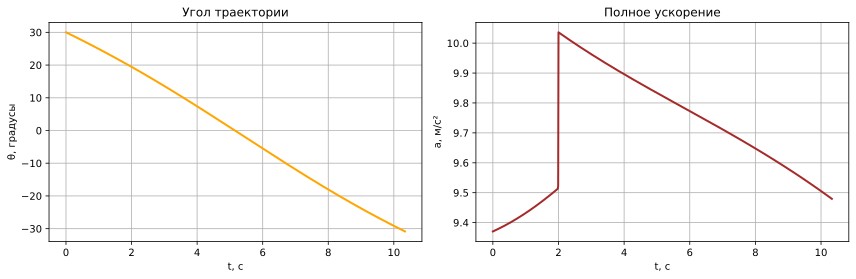

In [65]:
# ========== Дополнительные графики ==========
# График угла траектории
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
theta_traj = np.arctan2(Y_scipy[:, 3], Y_scipy[:, 2]) * 180 / np.pi
plt.plot(t_scipy, theta_traj, 'orange', linewidth=2)
plt.grid(True)
plt.xlabel('t, с')
plt.ylabel('θ, градусы')
plt.title('Угол траектории')

# График ускорений
plt.subplot(1, 2, 2)
# Вычисляем ускорения
accel = np.zeros((len(t_scipy)-1, 2))
for i in range(len(t_scipy)-1):
    dt_local = t_scipy[i+1] - t_scipy[i]
    accel[i, 0] = (Y_scipy[i+1, 2] - Y_scipy[i, 2]) / dt_local
    accel[i, 1] = (Y_scipy[i+1, 3] - Y_scipy[i, 3]) / dt_local

accel_total = np.sqrt(accel[:, 0]**2 + accel[:, 1]**2)
plt.plot(t_scipy[:-1], accel_total, 'brown', linewidth=2)
plt.grid(True)
plt.xlabel('t, с')
plt.ylabel('a, м/с²')
plt.title('Полное ускорение')

plt.tight_layout()
plt.show()


In [66]:
# ========== Дополнительная информация ==========
print("=== РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ ===")
print(f"Время полета: {t_scipy[-1]:.2f} с")
print(f"Дальность полета: {Y_scipy[-1, 0]:.2f} м")
print(f"Максимальная высота: {np.max(Y_scipy[:, 1]):.2f} м")
print(f"Финальная скорость: {np.sqrt(Y_scipy[-1, 2]**2 + Y_scipy[-1, 3]**2):.2f} м/с")
print(f"Максимальная скорость: {np.max(V_total):.2f} м/с")

=== РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ ===
Время полета: 10.34 с
Дальность полета: 893.14 м
Максимальная высота: 130.25 м
Финальная скорость: 97.62 м/с
Максимальная скорость: 100.00 м/с
